In [ ]:
import os
from functools import partial
from time import strftime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

tf.config.list_physical_devices("GPU")

In [2]:
# Get project files
#!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
#!unzip cats_and_dogs.zip

PATH = "cats_and_dogs"

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")
test_dir = os.path.join(PATH, "test")

# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# 3
CLASS_LABELS = ("cat", "dog")


def parse_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    filename = tf.strings.split(image_path, "/")[-1]
    class_name = tf.strings.split(filename, ".")[0]
    label_index = tf.cast(tf.equal(class_name, CLASS_LABELS[1]), tf.int32)
    return image, label_index


preprocessing_layer = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(scale=1.0 / 255),
        tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH, pad_to_aspect_ratio=True),
    ]
)


def get_dataset(directory, cache=False, shuffle=False, batch=True):
    ds = (
        tf.data.Dataset.list_files([directory + _ for _ in ["/*/*.jpg", "/*.jpg"]])
        .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            lambda image, label_index: (preprocessing_layer(image), label_index),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    )

    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(2_000)
    if batch:
        ds = ds.batch(batch_size)
    return ds.prefetch(tf.data.AUTOTUNE)


train_ds = get_dataset(train_dir, cache=True, shuffle=True)
validation_ds = get_dataset(validation_dir, cache=True)
test_ds = get_dataset(test_dir)

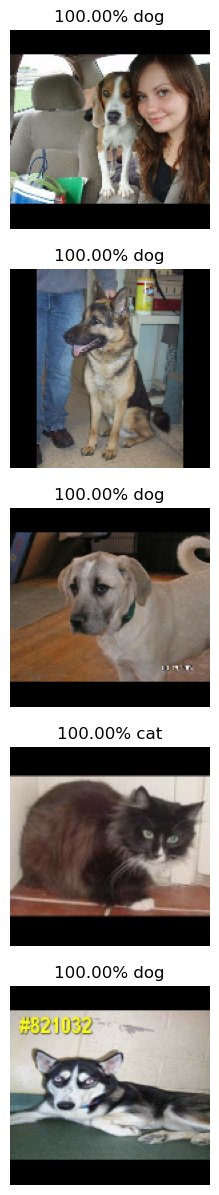

In [4]:
# 4
def plot_images(images_arr, probabilities=False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis("off")
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img, vmin=0, vmax=1)
            ax.axis("off")
            if probability > 0.5:
                ax.set_title("%.2f" % (probability * 100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1 - probability) * 100) + "% cat")
    plt.show()


sample_training_images, sample_training_labels = next(iter(train_ds))
sample_training_images, sample_training_labels = (
    sample_training_images[:5],
    sample_training_labels[:5].numpy(),
)
plot_images(sample_training_images, sample_training_labels)

In [5]:
# 5
data_augmentation_layer = tf.keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.25, value_range=(0, 1)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(
            height_factor=0.1,
            fill_mode="constant",
        ),
        tf.keras.layers.RandomTranslation(
            height_factor=0.1,
            width_factor=0.1,
            fill_mode="constant",
        ),
        tf.keras.layers.RandomRotation(
            0.05,
            fill_mode="constant",
        ),
    ]
)

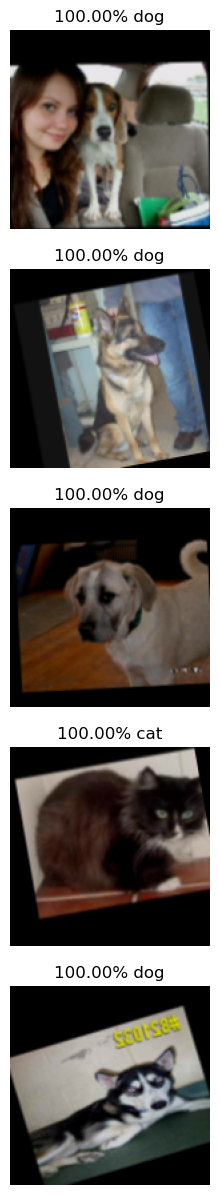

In [6]:
# 6
augmented_images = data_augmentation_layer(sample_training_images, training=True)

plot_images(augmented_images, sample_training_labels)

In [7]:
# 7

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        data_augmentation_layer,
        DefaultConv2D(filters=64, kernel_size=7),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

model.compile(
    loss="binary_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,741,441 (44.79 MB)

 Trainable params: 11,741,441 (44.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            f"logs/{strftime('run_%Y_%m_%d_%H_%M_%S')}",
        ),
    ],
)

I0000 00:00:1748698233.028000 3715168 service.cc:148] XLA service 0x317714fa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748698233.028030 3715168 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1748698233.032547 3715168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 340s 21s/step - accuracy: 0.5225 - loss: 2.5571 - val_accuracy: 0.5280 - val_loss: 0.6930
Restoring model weights from the end of the best epoch: 1.


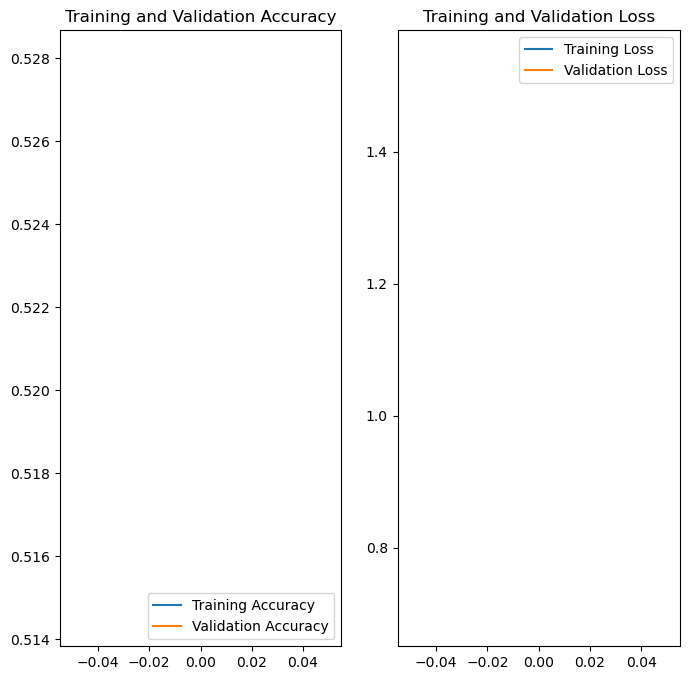

In [ ]:
# 9
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [11]:
# 10
probabilities = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [15]:
# 11
answers = [
    1,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
]

correct = 0

for probability, answer in zip(probabilities, answers):
    if np.round(probability) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(
    f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs."
)

if passed_challenge:
    print("You passed the challenge!")
else:
    print(
        "You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!"
    )

Your model correctly identified 48.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
